In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.model_selection import StratifiedShuffleSplit

from active_learning_ratio_estimation.dataset import RatioDataset
from active_learning_ratio_estimation.util import ideal_classifier_probs, negative_log_likelihood_ratio
from active_learning_ratio_estimation.model import RegularRatioModel, BayesianRatioModel

%matplotlib inline

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
def triple_mixture(gamma):
    mixture_probs = [
        0.5 * (1 - gamma),
        0.5 * (1 - gamma),
        gamma
    ]
    gaussians = [
        tfd.Normal(loc=-2, scale=0.75),
        tfd.Normal(loc=0, scale=2),
        tfd.Normal(loc=1, scale=0.5)
    ]
    dist = tfd.Mixture(
        cat=tfd.Categorical(probs=mixture_probs),
        components=gaussians
    )
    return dist

In [3]:
# Build dataset
theta_0 = 0.05
theta_1 = 0.00
n_samples_per_theta = int(2e5)

ds = RatioDataset(
    n_samples_per_theta=n_samples_per_theta,
    simulator_func=triple_mixture,
    theta_0_dist=theta_0,
    theta_1_dist=theta_1
)

ds.dataframe.head()

,x,theta_0,theta_1,y
0,-0.459056,0.05,0.0,1
1,-3.096241,0.05,0.0,1
2,-2.068185,0.05,0.0,1
3,-2.275229,0.05,0.0,0
4,-1.352379,0.05,0.0,0


In [4]:
# hyperparams
epochs = 20
patience = 2
validation_split = 0.1
n_hidden = (10, 10)
n_samples = int((1-validation_split) * len(ds))


fit_kwargs = dict(
    epochs=epochs,
    validation_split=validation_split,
    callbacks=[tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=patience, min_delta=5e-4)],
)

In [5]:
# regular, uncalibrated model
regular_uncalibrated = RegularRatioModel(parameterisation=0, n_samples=n_samples,
                                         n_hidden=n_hidden, activation='tanh',
                                         fit_kwargs=fit_kwargs, calibration_method=None)

# bayesian, uncalibrated model
bayesian_uncalibrated = BayesianRatioModel(parameterisation=0, n_samples=n_samples,
                                           n_hidden=n_hidden, activation='relu',
                                           fit_kwargs=fit_kwargs, calibration_method=None)


# regular, calibrated model
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=1)
regular_calibrated = RegularRatioModel(parameterisation=0, n_samples=n_samples,
                                       n_hidden=n_hidden, activation='tanh',
                                       fit_kwargs=fit_kwargs, calibration_method='sigmoid',
                                       cv=cv)

In [6]:
x = np.linspace(-5, 5, int(1e4))


def fit_and_predict(clf):
    clf.fit_dataset(ds)
    y_pred = clf.predict_proba(x, theta_0, theta_1)[:, 1].squeeze()
    lr_estimate = clf.predict_likelihood_ratio(x, theta_0, theta_1).squeeze()
    nllr = -np.log(lr_estimate)
    return clf, y_pred, nllr

In [7]:
# Fit and predict models
models = dict()
y_preds = dict()
nllrs = dict()


for model_name, clf in [
    ('Regular Uncalibrated', regular_uncalibrated),
    ('Bayesian Uncalibrated', bayesian_uncalibrated),
    ('Regular Calibrated', regular_calibrated)
]:
    
    print(f'\n******* Fitting {model_name} *******\n')
    clf, y_pred, nllr = fit_and_predict(clf)
    models[model_name] = clf
    y_preds[model_name] = y_pred
    nllrs[model_name] = nllr


******* Fitting Regular Uncalibrated *******

Train on 360000 samples, validate on 40000 samples
Epoch 1/20
360000/360000 [==============================] - 20s 55us/sample - loss: 0.6924 - val_loss: 0.6921
Epoch 2/20
360000/360000 [==============================] - 19s 52us/sample - loss: 0.6922 - val_loss: 0.6918
Epoch 3/20
360000/360000 [==============================] - 19s 53us/sample - loss: 0.6920 - val_loss: 0.6917

******* Fitting Bayesian Uncalibrated *******

Instructions for updating:
Please use `layer.add_weight` method instead.
Train on 360000 samples, validate on 40000 samples
Epoch 1/20
360000/360000 [==============================] - 39s 107us/sample - loss: 0.6931 - val_loss: 0.6925
Epoch 2/20
360000/360000 [==============================] - 36s 101us/sample - loss: 0.6926 - val_loss: 0.6923
Epoch 3/20
360000/360000 [==============================] - 37s 102us/sample - loss: 0.6925 - val_loss: 0.6922
Epoch 4/20
360000/360000 [==============================] - 37s 102

In [8]:
# Add ideal predictions
y_preds['Ideal'] = ideal_classifier_probs(x, triple_mixture, theta_0, theta_1)
nllrs['True'] = negative_log_likelihood_ratio(x, triple_mixture, theta_0, theta_1)
y_preds = pd.DataFrame(y_preds, index=x)
nllrs = pd.DataFrame(nllrs, index=x)

# Take a rolling mean of the Bayesian predictions to reduce MC noise
y_preds['Bayesian Uncalibrated'] = y_preds['Bayesian Uncalibrated'].rolling(5, center=True).mean()
nllrs['Bayesian Uncalibrated'] = nllrs['Bayesian Uncalibrated'].rolling(5, center=True).mean()

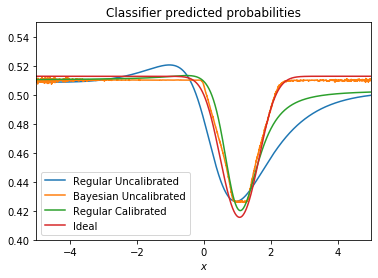

In [9]:
# Plot predictions for classifier decision function
y_preds.plot()
plt.xlim([-5, 5])
plt.ylim([0.4, 0.55])
plt.title('Classifier predicted probabilities')
plt.xlabel('$x$')
plt.show()

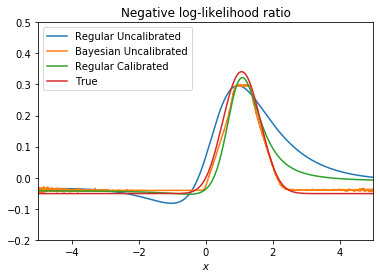

In [10]:
# Plot predictions for negative log likelihood ratio
nllrs.plot()
plt.xlim([-5, 5])
plt.ylim([-0.2, 0.5])
plt.title('Negative log-likelihood ratio')
plt.xlabel('$x$')
plt.show()

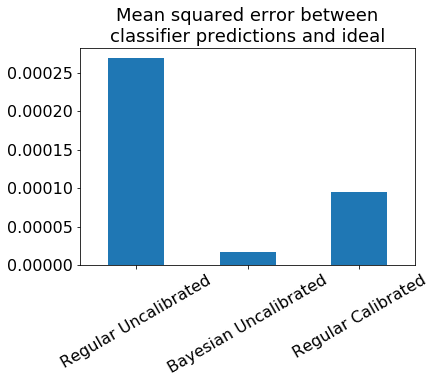

In [11]:
mses = pd.Series(dtype=float)

for model_name in models.keys():
    mse = np.mean((y_preds[model_name] - y_preds['Ideal'])**2)
    mses[model_name] = mse

mses.plot.bar(fontsize=16, rot=30)
plt.title('Mean squared error between\nclassifier predictions and ideal', fontsize=18)
plt.show()